In [ ]:
import argparse
import json
import os
import matplotlib.pyplot as plt
import torch
import yaml
from dataloader import ZFSliceDataset, SimulatedDataset, SimulatedSPFDataset
from einops import rearrange
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
from transform import VideoRotate, VideoDiffeo, SubsampleTime, MonophasicTimeWarp, TemporalNoise, TimeReverse
from ei import EILoss
from mc import MCLoss
from lsfpnet_encoding import LSFPNet, ArtifactRemovalLSFPNet
from radial_lsfp import MCNUFFT
from utils import prep_nufft, log_gradient_stats, plot_enhancement_curve, get_cosine_ei_weight, plot_reconstruction_sample, get_git_commit, save_checkpoint, load_checkpoint, to_torch_complex, GRASPRecon, sliding_window_inference, set_seed
from eval import eval_grasp, eval_sample

In [3]:
# load data
split_file = "/gpfs/data/karczmar-lab/workspaces/rachelgordon/breastMRI-recon/ddei/data/data_split.json"
with open(split_file, "r") as fp:
    splits = json.load(fp)

val_patient_ids = splits["val"]
val_dro_patient_ids = splits["val_dro"]

In [4]:
root_dir = "/ess/scratch/scratch1/rachelgordon/dro_dataset"
model_type = "LSFPNet"

eval_spf_dataset = SimulatedSPFDataset(
    root_dir=root_dir, 
    model_type=model_type, 
    patient_ids=val_dro_patient_ids,
    )


eval_spf_loader = DataLoader(
    eval_spf_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=4,
)

Found 15 simulated samples in /ess/scratch/scratch1/rachelgordon/dro_dataset/dro_18frames for 18 frames.


In [5]:
device = torch.device("cuda")
N_samples = 640
exp_name = "plot_grasp_metrics"
output_dir = os.path.join("output", exp_name)
eval_dir = os.path.join(output_dir, "eval_results")

In [6]:
MAIN_EVALUATION_PLAN = [
            {
                "spokes_per_frame": 2,
                "num_frames": 144, # 2 * 144 = 288 total spokes
                "description": "Stress test: max temporal points, 2 spokes"
            },
            {
                "spokes_per_frame": 4,
                "num_frames": 72, # 4 * 72 = 288 total spokes
                "description": "Stress test: max temporal points, 4 spokes"
            },
            {
                "spokes_per_frame": 8,
                "num_frames": 36, # 8 * 36 = 288 total spokes
                "description": "High temporal resolution"
            },
            {
                "spokes_per_frame": 16,
                "num_frames": 18, # 16 * 18 = 288 total spokes
                "description": "High temporal resolution"
            },
            {
                "spokes_per_frame": 24,
                "num_frames": 12, # 24 * 12 = 288 total spokes
                "description": "Good temporal resolution"
            },
            {
                "spokes_per_frame": 32,
                "num_frames": 8, # 36 * 8 = 288 total spokes
                "description": "Standard temporal resolution"
            },
        ]

In [22]:
spf_grasp_ssim = {}
spf_grasp_psnr = {}
spf_grasp_mse = {}
spf_grasp_lpips = {}
spf_grasp_dc_mse = {}
spf_grasp_dc_mae = {}
spf_grasp_corr = {}
spf_raw_dc_mse = {}
spf_raw_dc_mae = {}
spf_raw_grasp_dc_mse = {}
spf_raw_grasp_dc_mae = {}

for eval_config in MAIN_EVALUATION_PLAN:
                
                stress_test_grasp_ssims = []
                stress_test_grasp_psnrs = []
                stress_test_grasp_mses = []
                stress_test_grasp_lpipses = []
                stress_test_grasp_dc_mses = []
                stress_test_grasp_dc_maes = []
                stress_test_grasp_corrs = []

                spokes = eval_config["spokes_per_frame"]
                num_frames = eval_config["num_frames"]

                eval_spf_dataset.spokes_per_frame = spokes
                eval_spf_dataset.num_frames = num_frames
                eval_spf_dataset._update_sample_paths()
                
                
                for csmap, ground_truth, grasp_img, mask, grasp_path in eval_spf_loader:

                    print("grasp_path: ", grasp_path)


                    csmap = csmap.squeeze(0).to(device)   # Remove batch dim
                    ground_truth = ground_truth.to(device) # Shape: (1, 2, T, H, W)

                    # SIMULATE KSPACE
                    ktraj, dcomp, nufft_ob, adjnufft_ob = prep_nufft(N_samples, spokes, num_frames)
                    physics = MCNUFFT(nufft_ob.to(device), adjnufft_ob.to(device), ktraj.to(device), dcomp.to(device))

                    sim_kspace = physics(False, ground_truth, csmap)

                    kspace = sim_kspace.squeeze(0).to(device) # Remove batch dim


                    # check if GRASP image exists or if we need to perform GRASP recon
                    # if type(grasp_img) is int or len(grasp_img.shape) == 1:
                    #     print(f"No GRASP file found, performing reconstruction with {spokes} spokes/frame and {num_frames} frames.")

                    #     grasp_img = GRASPRecon(csmap, sim_kspace, spokes, num_frames, grasp_path[0])

                    #     grasp_recon_torch = torch.from_numpy(grasp_img).permute(2, 0, 1) # T, H, W
                    #     grasp_recon_torch = torch.stack([grasp_recon_torch.real, grasp_recon_torch.imag], dim=0)

                    #     grasp_img = torch.flip(grasp_recon_torch, dims=[-3])
                    #     grasp_img = torch.rot90(grasp_img, k=3, dims=[-3,-1]).unsqueeze(0)

                    grasp_img = grasp_img.to(device)

                    ground_truth = torch.stack([ground_truth.real, ground_truth.imag], dim=1)
                    ground_truth = rearrange(ground_truth, 'b i h w t -> b i t h w')


                    ## Evaluation
                    # ssim, psnr, mse, lpips, dc_mse, dc_mae, recon_corr, grasp_corr = eval_sample(kspace, csmap, ground_truth, x_recon, physics, mask, grasp_img, acceleration, int(spokes), eval_dir, f"{spokes}spf", device)
                    # stress_test_ssims.append(ssim)
                    # stress_test_psnrs.append(psnr)
                    # stress_test_mses.append(mse)
                    # stress_test_lpipses.append(lpips)
                    # stress_test_dc_mses.append(dc_mse)
                    # stress_test_dc_maes.append(dc_mae)

                    # if recon_corr is not None:
                    #     stress_test_corrs.append(recon_corr)
                    #     stress_test_grasp_corrs.append(grasp_corr)


                    ssim_grasp, psnr_grasp, mse_grasp, lpips_grasp, dc_mse_grasp, dc_mae_grasp = eval_grasp(kspace, csmap, ground_truth, grasp_img, physics, device, eval_dir)

                    stress_test_grasp_ssims.append(ssim_grasp)
                    stress_test_grasp_psnrs.append(psnr_grasp)
                    stress_test_grasp_mses.append(mse_grasp)
                    stress_test_grasp_lpipses.append(lpips_grasp)
                    stress_test_grasp_dc_mses.append(dc_mse_grasp)
                    stress_test_grasp_dc_maes.append(dc_mae_grasp)

                spf_grasp_ssim[spokes] = np.mean(stress_test_grasp_ssims)
                spf_grasp_psnr[spokes] = np.mean(stress_test_grasp_psnrs)
                spf_grasp_mse[spokes] = np.mean(stress_test_grasp_mses)
                spf_grasp_lpips[spokes] = np.mean(stress_test_grasp_lpipses)
                spf_grasp_dc_mse[spokes] = np.mean(stress_test_grasp_dc_mses)
                spf_grasp_dc_mae[spokes] = np.mean(stress_test_grasp_dc_maes)
                spf_grasp_corr[spokes] = np.mean(stress_test_grasp_corrs)



                    # spf_grasp_ssim[spokes] = np.mean(stress_test_grasp_ssims)
                    # spf_grasp_psnr[spokes] = np.mean(stress_test_grasp_psnrs)
                    # spf_grasp_mse[spokes] = np.mean(stress_test_grasp_mses)
                    # spf_grasp_lpips[spokes] = np.mean(stress_test_grasp_lpipses)
                    # spf_grasp_dc_mse[spokes] = np.mean(stress_test_grasp_dc_mses)
                    # spf_grasp_dc_mae[spokes] = np.mean(stress_test_grasp_dc_maes)
                    # spf_grasp_corr[spokes] = np.mean(stress_test_grasp_corrs)

Found 15 simulated samples in /ess/scratch/scratch1/rachelgordon/dro_dataset/dro_144frames for 144 frames.
  Testing 2 spokes/frame with 144 frames.  Testing 2 spokes/frame with 144 frames.  Testing 2 spokes/frame with 144 frames.

loading data from  
/ess/scratch/scratch1/rachelgordon/dro_dataset/dro_144frames/sample_007_sub7
loading data from  /ess/scratch/scratch1/rachelgordon/dro_dataset/dro_144frames/sample_012_sub12
loading data from    Testing 2 spokes/frame with 144 frames.
/ess/scratch/scratch1/rachelgordon/dro_dataset/dro_144frames/sample_005_sub5
loading data from  /ess/scratch/scratch1/rachelgordon/dro_dataset/dro_144frames/sample_020_sub20
  Testing 2 spokes/frame with 144 frames.
loading data from  /ess/scratch/scratch1/rachelgordon/dro_dataset/dro_144frames/sample_031_sub31
  Testing 2 spokes/frame with 144 frames.
loading data from  /ess/scratch/scratch1/rachelgordon/dro_dataset/dro_144frames/sample_021_sub21
  Testing 2 spokes/frame with 144 frames.
loading data from  

/gpfs/data/karczmar-lab/workspaces/rachelgordon/micromamba/envs/recon_mri/lib/python3.11/site-packages/torchmetrics/functional/image/lpips.py:323: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this expe

  Testing 2 spokes/frame with 144 frames.
loading data from  /ess/scratch/scratch1/rachelgordon/dro_dataset/dro_144frames/sample_034_sub34
grasp_path:  ('/ess/scratch/scratch1/rachelgordon/dro_dataset/dro_144frames/sample_007_sub7/grasp_spf2_frames144.npy',)
  Testing 2 spokes/frame with 144 frames.
loading data from  /ess/scratch/scratch1/rachelgordon/dro_dataset/dro_144frames/sample_037_sub37
grasp_path:  ('/ess/scratch/scratch1/rachelgordon/dro_dataset/dro_144frames/sample_012_sub12/grasp_spf2_frames144.npy',)
  Testing 2 spokes/frame with 144 frames.
loading data from  /ess/scratch/scratch1/rachelgordon/dro_dataset/dro_144frames/sample_040_sub40
grasp_path:  ('/ess/scratch/scratch1/rachelgordon/dro_dataset/dro_144frames/sample_020_sub20/grasp_spf2_frames144.npy',)
  Testing 2 spokes/frame with 144 frames.
loading data from  /ess/scratch/scratch1/rachelgordon/dro_dataset/dro_144frames/sample_044_sub44
grasp_path:  ('/ess/scratch/scratch1/rachelgordon/dro_dataset/dro_144frames/sample

/gpfs/data/karczmar-lab/workspaces/rachelgordon/micromamba/envs/recon_mri/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/gpfs/data/karczmar-lab/workspaces/rachelgordon/micromamba/envs/recon_mri/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


  Testing 4 spokes/frame with 72 frames.
loading data from    Testing 4 spokes/frame with 72 frames./ess/scratch/scratch1/rachelgordon/dro_dataset/dro_72frames/sample_005_sub5

  Testing 4 spokes/frame with 72 frames.
loading data from  /ess/scratch/scratch1/rachelgordon/dro_dataset/dro_72frames/sample_012_sub12loading data from  
  Testing 4 spokes/frame with 72 frames./ess/scratch/scratch1/rachelgordon/dro_dataset/dro_72frames/sample_007_sub7

loading data from  /ess/scratch/scratch1/rachelgordon/dro_dataset/dro_72frames/sample_020_sub20
  Testing 4 spokes/frame with 72 frames.  Testing 4 spokes/frame with 72 frames.
loading data from  
/ess/scratch/scratch1/rachelgordon/dro_dataset/dro_72frames/sample_030_sub30loading data from 
 /ess/scratch/scratch1/rachelgordon/dro_dataset/dro_72frames/sample_021_sub21
  Testing 4 spokes/frame with 72 frames.
  Testing 4 spokes/frame with 72 frames.loading data from  /ess/scratch/scratch1/rachelgordon/dro_dataset/dro_72frames/sample_031_sub31

lo

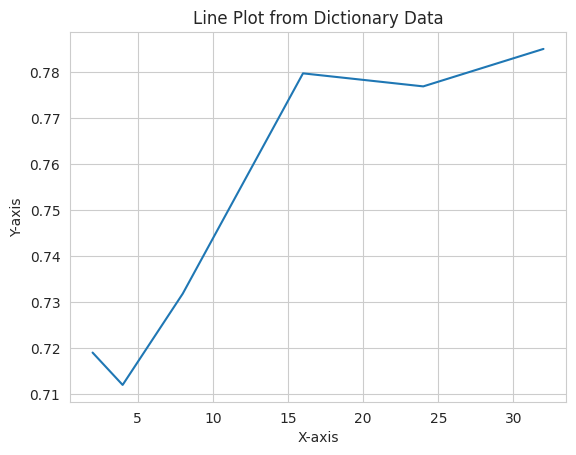

In [24]:
import seaborn as sns

# Create the line plot
sns.lineplot(x=list(spf_grasp_ssim.keys()), y=list(spf_grasp_ssim.values()))

plt.title("Line Plot from Dictionary Data")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()

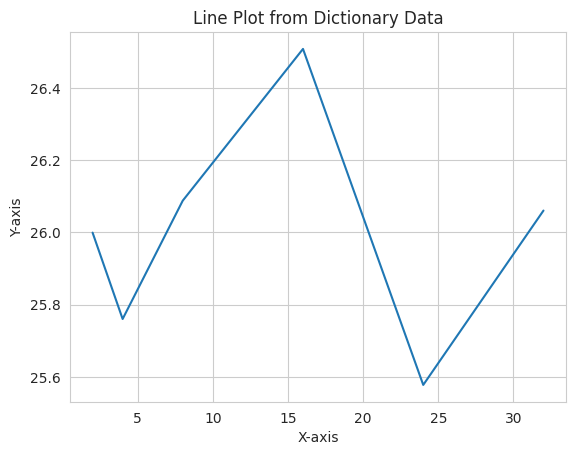

In [25]:
# Create the line plot
sns.lineplot(x=list(spf_grasp_psnr.keys()), y=list(spf_grasp_psnr.values()))

plt.title("Line Plot from Dictionary Data")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()

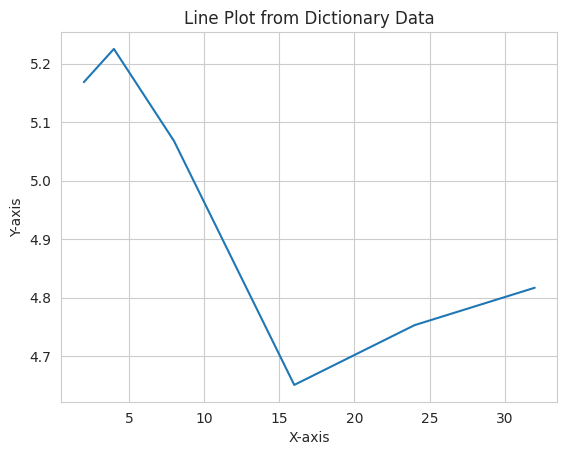

In [26]:
# Create the line plot
sns.lineplot(x=list(spf_grasp_mse.keys()), y=list(spf_grasp_mse.values()))

plt.title("Line Plot from Dictionary Data")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()

In [42]:
import math

N_full = 320 * math.pi / 2

acceleration_lpips = {}
for spf in spf_grasp_lpips.keys():

    acceleration = N_full / int(spf)
    acceleration_lpips[acceleration] = spf_grasp_lpips[spf]

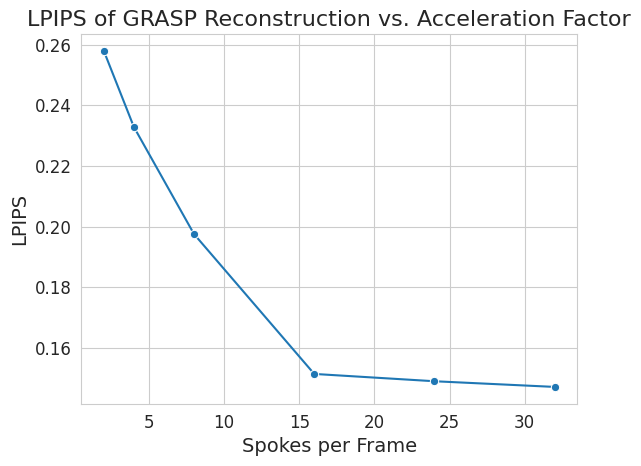

In [38]:
# Create the line plot
sns.lineplot(x=list(spf_grasp_lpips.keys()), y=list(spf_grasp_lpips.values()), marker='o')

plt.title('LPIPS of GRASP Reconstruction vs. Acceleration Factor', fontsize=16)
plt.xlabel("Spokes per Frame", fontsize=14)
plt.ylabel("LPIPS", fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True) # Add a grid for better readability

plt.show()

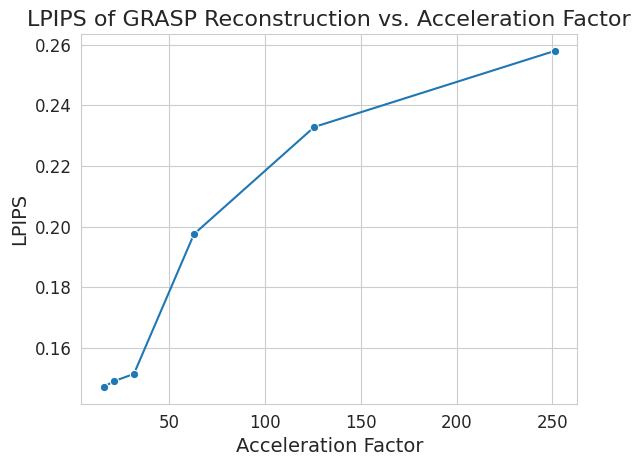

In [44]:
# Create the line plot
sns.lineplot(x=list(acceleration_lpips.keys()), y=list(acceleration_lpips.values()), marker='o')

plt.title('LPIPS of GRASP Reconstruction vs. Acceleration Factor', fontsize=16)
plt.xlabel("Acceleration Factor", fontsize=14)
plt.ylabel("LPIPS", fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True) # Add a grid for better readability

plt.show()